## Imports and Mounting

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 8.0 MB/s eta 0:00:00


In [5]:
# Imports

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import ConcatDataset, DataLoader, random_split, Subset

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10

from torchmetrics import Accuracy, Recall, Precision, F1Score, ConfusionMatrix

from sklearn.model_selection import KFold

import numpy as np

from tqdm import tqdm
import matplotlib.pyplot as plt

## Data Exploration

Implement data loading and preprocessing techniques including normalization, resizing, and data augmentation.

In [ ]:
# Normalize the original dataset via transform module
original_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Augment and normalize the original dataset via transform module
augmented_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [ ]:
# Load CIFAR-10 dataset and apply and transformation and normalization
dataset = CIFAR10(root='./data', train=True,
                            download=True, transform=augmented_transform)
testset = CIFAR10(root='./data', train=False,
                            download=False, transform=original_transform)


# Calculate the sizes for training and validation sets
train_size = int(.8 * len(dataset))
val_size = int(.2 * len(dataset))

# Split the dataset into training and validation sets
trainset, valset = random_split(dataset, [train_size, val_size])

# Print the len
print("Trainset size: {}". format(len(trainset)))
print("Validation set size: {}". format(len(valset)))
print("Testset size: {}". format(len(testset)))


100%|██████████| 170498071/170498071 [00:02<00:00, 70320050.81it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Trainset size: 40000
Validation set size: 10000
Testset size: 10000


In [ ]:
batch_size = 64

# Create data loaders for train and test sets
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)

# Classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



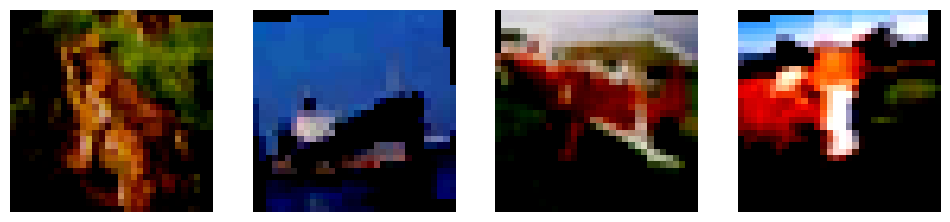

In [ ]:
images, _ = next(iter(trainloader))

# Generate random indices for selecting images
random_indices = np.random.randint(0, images.size(0), size=4)

# Create a subplot for each image
fig, axes = plt.subplots(1, 4, figsize=(12, 3))

for i, ax in enumerate(axes):
    # Extract the selected image
    random_image = images[random_indices[i]]

    # If the image is in torch tensor, convert it to a NumPy array
    random_image = random_image.numpy()

    # If the image has 3 channels, transpose it to (H, W, C) for display
    if random_image.shape[0] == 3:
        random_image = np.transpose(random_image, (1, 2, 0))

    # Display the image
    ax.imshow(random_image)
    ax.axis('off')

plt.show();

## Model Architecture

Design a CNN model from scratch. Ensure the model is appropriate for the task but not overly complex.

In [6]:
class CNN1(nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 8 * 8, 512),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x



class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Flatten(),
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 8 * 8, 10)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x


## Training and Evaluation

Tried two different optimizers are used.

In [ ]:
# Create a model using CNN1 model
net = CNN1()

In [ ]:
# Set to variables of criterion and optimizer of Cross Entropy and Mini-Batch Gradient Decent, respectively.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# Set the number of folds
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
batch_size = 64

# Loop over folds
for fold, (train_indices, val_indices) in enumerate(kf.split(trainset)):
    print(f"Training on Fold {fold + 1}/{num_folds}")

    # Create data loaders for the current fold
    train_subset = Subset(trainset, train_indices)
    val_subset = Subset(trainset, val_indices)

    # Create loaders for the train set and the validation dataset
    trainloader = DataLoader(train_subset, batch_size=64, shuffle=True)
    valloader = DataLoader(val_subset, batch_size=64, shuffle=False)

    # Training loop
    for epoch in range(2):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(tqdm(trainloader, desc=f'Epoch {epoch + 1} (Fold {fold + 1}/{num_folds})'), 0):
            inputs, labels = data
            # Reset the gradient
            optimizer.zero_grad()
            # Forward pass
            outputs = net(inputs)
            # Loss computing
            loss = criterion(outputs, labels)
            # Backward pass
            loss.backward()
            # Optimize model
            optimizer.step()

            running_loss += loss.item()
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0

    # Validation loop
    net.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in tqdm(valloader, desc=f'Validation (Fold {fold + 1}/{num_folds})'):
            inputs, labels = data
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            # Set total and correct
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    # Print the validation loss and accuracy, respectively
    print(f'Validation loss: {val_loss / len(valloader):.3f}')
    print(f'Validation accuracy: {100 * correct / total:.2f}%')

    net.train()  # Set the model back to training mode

print('Finished Training with Cross Validation')

Training on Fold 1/5


Validation (Fold 1/5): 100%|██████████| 313/313 [01:18<00:00,  3.96it/s]


Validation loss: 1.623
Validation accuracy: 42.08%
Training on Fold 2/5


Validation (Fold 2/5): 100%|██████████| 313/313 [01:36<00:00,  3.25it/s]


Validation loss: 1.458
Validation accuracy: 48.04%
Training on Fold 3/5


Validation (Fold 3/5): 100%|██████████| 313/313 [01:34<00:00,  3.33it/s]


Validation loss: 1.362
Validation accuracy: 51.77%
Training on Fold 4/5


Validation (Fold 4/5): 100%|██████████| 313/313 [01:35<00:00,  3.29it/s]


Validation loss: 1.254
Validation accuracy: 55.56%
Training on Fold 5/5


Validation (Fold 5/5): 100%|██████████| 313/313 [01:19<00:00,  3.91it/s]

Validation loss: 1.195
Validation accuracy: 57.65%
Finished Training with Cross Validation


In [ ]:
# Set to variables of criterion and optimizer of Cross Entropy and Mini-Batch Gradient Decent, respectively.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
train_acc = Accuracy(task='multiclass', num_classes=10)
val_acc = Accuracy(task='multiclass', num_classes=10)

In [ ]:
# Training loop
num_epochs = 80
for epoch in range(num_epochs):
    running_loss = 0
    num_processed = 0
    for i, (inputs, labels) in enumerate(tqdm(trainloader, desc=f'Training {epoch+1}')):
        # Reset the gradient
        optimizer.zero_grad()
        # Forward pass
        outputs = net(inputs)
        # Loss computing
        loss = criterion(outputs, labels)
        # Backward pass
        loss.backward()
        # Optimize model
        optimizer.step()
        _, predicted = outputs.max(1)
        # Accuracy computing
        train_acc(predicted, labels)
        running_loss += loss.item()
        num_processed += len(labels)

    # Validation loop
    net.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in tqdm(valloader, desc=f'Validation'):
            inputs, labels = data
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            # Set total and correct
            _, predicted = outputs.max(1)
            val_acc(predicted, labels)

    net.train()

    # Print the training and validation loss and accuracy
    print(f'Training loss: {running_loss / num_processed:.3f}')
    print(f'Training accuracy: {100 * train_acc.compute():.3f}%')

    print(f'Validation loss: {val_loss / len(valloader):.3f}')
    print(f'Validation accuracy: {100 * val_acc.compute():.3f}%')


Validation: 100%|██████████| 157/157 [00:15<00:00,  9.86it/s]


Training loss: 0.024
Training accuracy: 45.948%
Validation loss: 1.252
Validation accuracy: 55.480%


Validation: 100%|██████████| 157/157 [00:14<00:00, 10.67it/s]


Training loss: 0.018
Training accuracy: 52.430%
Validation loss: 1.097
Validation accuracy: 58.410%


Validation: 100%|██████████| 157/157 [00:14<00:00, 10.69it/s]


Training loss: 0.016
Training accuracy: 56.302%
Validation loss: 1.011
Validation accuracy: 60.683%


Validation: 100%|██████████| 157/157 [00:14<00:00, 10.58it/s]


Training loss: 0.015
Training accuracy: 59.017%
Validation loss: 0.928
Validation accuracy: 62.452%


Validation: 100%|██████████| 157/157 [00:14<00:00, 10.62it/s]


Training loss: 0.014
Training accuracy: 61.141%
Validation loss: 0.878
Validation accuracy: 63.924%


Validation: 100%|██████████| 157/157 [00:14<00:00, 10.64it/s]


Training loss: 0.013
Training accuracy: 62.825%
Validation loss: 0.857
Validation accuracy: 65.018%


Validation: 100%|██████████| 157/157 [00:14<00:00, 10.54it/s]


Training loss: 0.012
Training accuracy: 64.232%
Validation loss: 0.826
Validation accuracy: 65.960%


Validation: 100%|██████████| 157/157 [00:14<00:00, 10.69it/s]


Training loss: 0.012
Training accuracy: 65.417%
Validation loss: 0.820
Validation accuracy: 66.688%


Validation: 100%|██████████| 157/157 [00:14<00:00, 10.83it/s]


Training loss: 0.011
Training accuracy: 66.455%
Validation loss: 0.803
Validation accuracy: 67.396%


Validation: 100%|██████████| 157/157 [00:14<00:00, 10.63it/s]


Training loss: 0.011
Training accuracy: 67.336%
Validation loss: 0.787
Validation accuracy: 67.921%


Validation: 100%|██████████| 157/157 [00:14<00:00, 10.57it/s]


Training loss: 0.011
Training accuracy: 68.118%
Validation loss: 0.794
Validation accuracy: 68.396%


Validation: 100%|██████████| 157/157 [00:14<00:00, 10.69it/s]


Training loss: 0.011
Training accuracy: 68.849%
Validation loss: 0.777
Validation accuracy: 68.798%


Validation: 100%|██████████| 157/157 [00:14<00:00, 10.79it/s]


Training loss: 0.010
Training accuracy: 69.491%
Validation loss: 0.845
Validation accuracy: 68.998%


Validation: 100%|██████████| 157/157 [00:14<00:00, 10.62it/s]


Training loss: 0.010
Training accuracy: 70.068%
Validation loss: 0.759
Validation accuracy: 69.349%


Validation: 100%|██████████| 157/157 [00:14<00:00, 10.52it/s]


Training loss: 0.010
Training accuracy: 70.621%
Validation loss: 0.760
Validation accuracy: 69.692%


Validation: 100%|██████████| 157/157 [00:14<00:00, 10.60it/s]


Training loss: 0.010
Training accuracy: 71.098%
Validation loss: 0.744
Validation accuracy: 69.997%


Validation: 100%|██████████| 157/157 [00:14<00:00, 10.76it/s]


Training loss: 0.010
Training accuracy: 71.548%
Validation loss: 0.764
Validation accuracy: 70.238%


Validation: 100%|██████████| 157/157 [00:15<00:00,  9.96it/s]


Training loss: 0.009
Training accuracy: 71.956%
Validation loss: 0.785
Validation accuracy: 70.419%


Validation: 100%|██████████| 157/157 [00:14<00:00, 10.61it/s]


Training loss: 0.009
Training accuracy: 72.332%
Validation loss: 0.757
Validation accuracy: 70.628%


Validation: 100%|██████████| 157/157 [00:14<00:00, 10.59it/s]


Training loss: 0.009
Training accuracy: 72.686%
Validation loss: 0.769
Validation accuracy: 70.820%


Validation: 100%|██████████| 157/157 [00:14<00:00, 10.83it/s]


Training loss: 0.009
Training accuracy: 73.018%
Validation loss: 0.730
Validation accuracy: 71.036%


Validation: 100%|██████████| 157/157 [00:14<00:00, 10.92it/s]


Training loss: 0.009
Training accuracy: 73.342%
Validation loss: 0.760
Validation accuracy: 71.218%


Validation: 100%|██████████| 157/157 [00:14<00:00, 10.68it/s]


Training loss: 0.009
Training accuracy: 73.639%
Validation loss: 0.759
Validation accuracy: 71.347%


Validation: 100%|██████████| 157/157 [00:14<00:00, 10.60it/s]


Training loss: 0.009
Training accuracy: 73.922%
Validation loss: 0.755
Validation accuracy: 71.501%


Validation: 100%|██████████| 157/157 [00:16<00:00,  9.55it/s]


Training loss: 0.009
Training accuracy: 74.188%
Validation loss: 0.774
Validation accuracy: 71.616%


Validation: 100%|██████████| 157/157 [00:14<00:00, 10.85it/s]


Training loss: 0.009
Training accuracy: 74.435%
Validation loss: 0.798
Validation accuracy: 71.715%


Validation: 100%|██████████| 157/157 [00:14<00:00, 10.61it/s]


Training loss: 0.009
Training accuracy: 74.669%
Validation loss: 0.758
Validation accuracy: 71.835%


Validation: 100%|██████████| 157/157 [00:14<00:00, 10.65it/s]


Training loss: 0.009
Training accuracy: 74.894%
Validation loss: 0.734
Validation accuracy: 71.986%


Validation: 100%|██████████| 157/157 [00:14<00:00, 10.64it/s]


Training loss: 0.008
Training accuracy: 75.110%
Validation loss: 0.765
Validation accuracy: 72.087%


Validation: 100%|██████████| 157/157 [00:14<00:00, 10.71it/s]


Training loss: 0.008
Training accuracy: 75.313%
Validation loss: 0.748
Validation accuracy: 72.180%


Validation: 100%|██████████| 157/157 [00:14<00:00, 10.95it/s]


Training loss: 0.008
Training accuracy: 75.512%
Validation loss: 0.748
Validation accuracy: 72.277%


Validation: 100%|██████████| 157/157 [00:16<00:00,  9.48it/s]


Training loss: 0.008
Training accuracy: 75.702%
Validation loss: 0.735
Validation accuracy: 72.393%


Validation: 100%|██████████| 157/157 [00:14<00:00, 10.70it/s]


Training loss: 0.008
Training accuracy: 75.871%
Validation loss: 0.756
Validation accuracy: 72.483%


Validation: 100%|██████████| 157/157 [00:14<00:00, 10.59it/s]


Training loss: 0.008
Training accuracy: 76.051%
Validation loss: 0.755
Validation accuracy: 72.568%


Validation: 100%|██████████| 157/157 [00:14<00:00, 10.90it/s]


Training loss: 0.008
Training accuracy: 76.221%
Validation loss: 0.749
Validation accuracy: 72.651%


Validation: 100%|██████████| 157/157 [00:14<00:00, 10.94it/s]


Training loss: 0.008
Training accuracy: 76.383%
Validation loss: 0.780
Validation accuracy: 72.732%


Validation: 100%|██████████| 157/157 [00:14<00:00, 10.73it/s]


Training loss: 0.008
Training accuracy: 76.540%
Validation loss: 0.755
Validation accuracy: 72.811%


Validation: 100%|██████████| 157/157 [00:14<00:00, 10.69it/s]


Training loss: 0.008
Training accuracy: 76.683%
Validation loss: 0.763
Validation accuracy: 72.869%


Validation: 100%|██████████| 157/157 [00:16<00:00,  9.37it/s]


Training loss: 0.008
Training accuracy: 76.831%
Validation loss: 0.767
Validation accuracy: 72.937%


Validation: 100%|██████████| 157/157 [00:14<00:00, 10.72it/s]


Training loss: 0.008
Training accuracy: 76.969%
Validation loss: 0.759
Validation accuracy: 73.008%


Validation: 100%|██████████| 157/157 [00:14<00:00, 10.67it/s]


Training loss: 0.008
Training accuracy: 77.099%
Validation loss: 0.748
Validation accuracy: 73.080%


Validation: 100%|██████████| 157/157 [00:14<00:00, 10.78it/s]


Training loss: 0.008
Training accuracy: 77.236%
Validation loss: 0.736
Validation accuracy: 73.146%


Validation: 100%|██████████| 157/157 [00:14<00:00, 10.75it/s]


Training loss: 0.008
Training accuracy: 77.368%
Validation loss: 0.771
Validation accuracy: 73.210%


Validation: 100%|██████████| 157/157 [00:14<00:00, 10.70it/s]


Training loss: 0.008
Training accuracy: 77.494%
Validation loss: 0.784
Validation accuracy: 73.262%


Validation: 100%|██████████| 157/157 [00:14<00:00, 10.80it/s]


Training loss: 0.008
Training accuracy: 77.616%
Validation loss: 0.763
Validation accuracy: 73.319%


Validation: 100%|██████████| 157/157 [00:14<00:00, 11.01it/s]


Training loss: 0.008
Training accuracy: 77.733%
Validation loss: 0.754
Validation accuracy: 73.386%


Validation: 100%|██████████| 157/157 [00:14<00:00, 11.02it/s]


Training loss: 0.008
Training accuracy: 77.848%
Validation loss: 0.752
Validation accuracy: 73.452%


Validation: 100%|██████████| 157/157 [00:14<00:00, 10.95it/s]


Training loss: 0.007
Training accuracy: 77.958%
Validation loss: 0.772
Validation accuracy: 73.505%


Validation: 100%|██████████| 157/157 [00:14<00:00, 11.08it/s]


Training loss: 0.007
Training accuracy: 78.063%
Validation loss: 0.763
Validation accuracy: 73.547%


Validation: 100%|██████████| 157/157 [00:14<00:00, 10.96it/s]


Training loss: 0.008
Training accuracy: 78.162%
Validation loss: 0.770
Validation accuracy: 73.596%


Validation: 100%|██████████| 157/157 [00:14<00:00, 10.94it/s]


Training loss: 0.007
Training accuracy: 78.261%
Validation loss: 0.753
Validation accuracy: 73.650%


Validation: 100%|██████████| 157/157 [00:14<00:00, 11.00it/s]


Training loss: 0.007
Training accuracy: 78.358%
Validation loss: 0.747
Validation accuracy: 73.701%


Validation: 100%|██████████| 157/157 [00:14<00:00, 11.01it/s]


Training loss: 0.007
Training accuracy: 78.449%
Validation loss: 0.751
Validation accuracy: 73.752%


Validation: 100%|██████████| 157/157 [00:14<00:00, 11.06it/s]


Training loss: 0.007
Training accuracy: 78.542%
Validation loss: 0.795
Validation accuracy: 73.780%


Validation: 100%|██████████| 157/157 [00:15<00:00, 10.38it/s]


Training loss: 0.007
Training accuracy: 78.633%
Validation loss: 0.774
Validation accuracy: 73.820%


Validation: 100%|██████████| 157/157 [00:14<00:00, 10.72it/s]


Training loss: 0.007
Training accuracy: 78.727%
Validation loss: 0.795
Validation accuracy: 73.849%


Validation: 100%|██████████| 157/157 [00:14<00:00, 10.55it/s]


Training loss: 0.007
Training accuracy: 78.819%
Validation loss: 0.768
Validation accuracy: 73.880%


Validation: 100%|██████████| 157/157 [00:14<00:00, 10.91it/s]


Training loss: 0.007
Training accuracy: 78.903%
Validation loss: 0.770
Validation accuracy: 73.921%


Validation: 100%|██████████| 157/157 [00:14<00:00, 11.03it/s]


Training loss: 0.007
Training accuracy: 78.983%
Validation loss: 0.779
Validation accuracy: 73.957%


Validation: 100%|██████████| 157/157 [00:15<00:00,  9.89it/s]


Training loss: 0.007
Training accuracy: 79.067%
Validation loss: 0.747
Validation accuracy: 74.003%


Validation: 100%|██████████| 157/157 [00:14<00:00, 11.05it/s]


Training loss: 0.007
Training accuracy: 79.144%
Validation loss: 0.766
Validation accuracy: 74.039%


Validation: 100%|██████████| 157/157 [00:14<00:00, 11.01it/s]


Training loss: 0.007
Training accuracy: 79.226%
Validation loss: 0.741
Validation accuracy: 74.089%


Validation: 100%|██████████| 157/157 [00:14<00:00, 11.03it/s]


Training loss: 0.007
Training accuracy: 79.305%
Validation loss: 0.771
Validation accuracy: 74.118%


Validation: 100%|██████████| 157/157 [00:14<00:00, 11.13it/s]


Training loss: 0.007
Training accuracy: 79.382%
Validation loss: 0.751
Validation accuracy: 74.154%


Validation: 100%|██████████| 157/157 [00:14<00:00, 11.00it/s]


Training loss: 0.007
Training accuracy: 79.452%
Validation loss: 0.773
Validation accuracy: 74.178%


Validation: 100%|██████████| 157/157 [00:14<00:00, 10.93it/s]


Training loss: 0.007
Training accuracy: 79.523%
Validation loss: 0.755
Validation accuracy: 74.208%


Validation: 100%|██████████| 157/157 [00:14<00:00, 10.92it/s]


Training loss: 0.007
Training accuracy: 79.595%
Validation loss: 0.757
Validation accuracy: 74.240%


Validation: 100%|██████████| 157/157 [00:14<00:00, 10.80it/s]


Training loss: 0.007
Training accuracy: 79.664%
Validation loss: 0.762
Validation accuracy: 74.270%


Validation: 100%|██████████| 157/157 [00:15<00:00,  9.84it/s]


Training loss: 0.007
Training accuracy: 79.729%
Validation loss: 0.791
Validation accuracy: 74.305%


Validation: 100%|██████████| 157/157 [00:14<00:00, 10.86it/s]


Training loss: 0.007
Training accuracy: 79.790%
Validation loss: 0.764
Validation accuracy: 74.342%


Validation: 100%|██████████| 157/157 [00:14<00:00, 11.00it/s]


Training loss: 0.007
Training accuracy: 79.858%
Validation loss: 0.789
Validation accuracy: 74.363%


Validation: 100%|██████████| 157/157 [00:14<00:00, 11.07it/s]


Training loss: 0.007
Training accuracy: 79.918%
Validation loss: 0.773
Validation accuracy: 74.394%


Validation: 100%|██████████| 157/157 [00:14<00:00, 10.99it/s]


Training loss: 0.007
Training accuracy: 79.976%
Validation loss: 0.771
Validation accuracy: 74.418%


Validation: 100%|██████████| 157/157 [00:14<00:00, 10.97it/s]


Training loss: 0.007
Training accuracy: 80.038%
Validation loss: 0.798
Validation accuracy: 74.434%


Validation: 100%|██████████| 157/157 [00:14<00:00, 10.92it/s]


Training loss: 0.007
Training accuracy: 80.098%
Validation loss: 0.781
Validation accuracy: 74.462%


Validation: 100%|██████████| 157/157 [00:14<00:00, 10.99it/s]


Training loss: 0.007
Training accuracy: 80.158%
Validation loss: 0.759
Validation accuracy: 74.490%


Validation: 100%|██████████| 157/157 [00:14<00:00, 10.86it/s]


Training loss: 0.007
Training accuracy: 80.215%
Validation loss: 0.765
Validation accuracy: 74.508%


Validation: 100%|██████████| 157/157 [00:14<00:00, 10.94it/s]


Training loss: 0.007
Training accuracy: 80.272%
Validation loss: 0.790
Validation accuracy: 74.522%


Validation: 100%|██████████| 157/157 [00:14<00:00, 10.68it/s]


Training loss: 0.007
Training accuracy: 80.330%
Validation loss: 0.813
Validation accuracy: 74.536%


Validation: 100%|██████████| 157/157 [00:14<00:00, 11.00it/s]


Training loss: 0.007
Training accuracy: 80.385%
Validation loss: 0.778
Validation accuracy: 74.556%


In [ ]:
torch.save(net, '/content/drive/MyDrive/modeladam.pth')

## Testing and Evaluation

In [ ]:
net = torch.load('/content/drive/MyDrive/modeladam.pth')
net.eval()  # Set the model to evaluation mode

criterion = nn.CrossEntropyLoss()
test_acc = Accuracy (task='multiclass', num_classes=10)
test_precision = Precision (task='multiclass', num_classes=10, average="weighted")
test_recall = Recall (task='multiclass', num_classes=10, average="weighted")
test_f1score = F1Score (task='multiclass', num_classes=10, average="weighted")

test_loss = 0.0
# correct = 0
# total = 0
# all_labels = []
# all_predictions = []

with torch.no_grad():
    for data in tqdm(testloader, desc='Testing'):
        inputs, labels = data
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Collect predictions and ground truth labels for later analysis
        _, predicted = outputs.max(1)
        test_acc(predicted, labels)
        test_precision(predicted, labels)
        test_recall(predicted, labels)
        test_f1score(predicted, labels)

# Print the test loss and accuracy
print(f'Test loss: {test_loss / len(testloader):.3f}')
print(f'Test accuracy: {100 * test_acc.compute():.2f}')
print(f'Test Precision: {100 * test_precision.compute():.2f}')
print(f'Test Recall: {100 * test_recall.compute():.2f}')
print(f'Test F1-score: {100 * test_f1score.compute():.2f}')

Testing: 100%|██████████| 157/157 [00:10<00:00, 15.33it/s]

Test loss: 0.768
Test accuracy: 77.34
Test Precision: 77.27
Test Recall: 77.34
Test F1-score: 77.11
